# 1. 데이터 로드 (Load Data & Packages)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
train=pd.read_csv('house-prices-advanced-regression-techniques/train.csv', index_col='Id')
test=pd.read_csv('house-prices-advanced-regression-techniques/test.csv', index_col='Id')
submission=pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv', index_col='Id')
data=train
print(train.shape, test.shape, submission.shape)

(1460, 80) (1459, 79) (1459, 1)


# 2. 데이터 분석하기
## 2.1. 타겟 변수 확인 (Distribution of Target)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

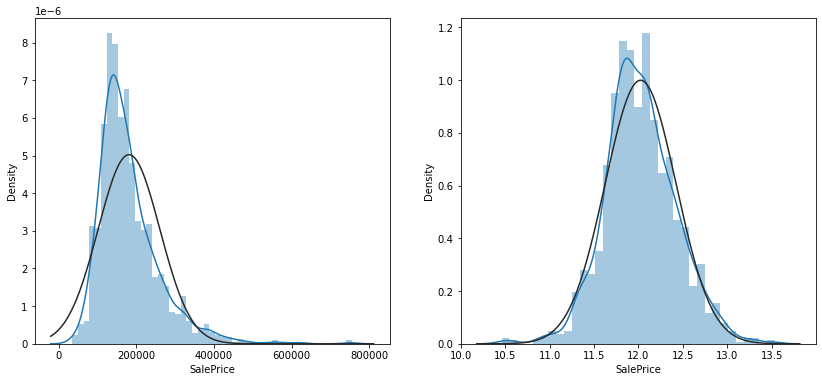

In [3]:
# 변수에 log를 취해 Right skewed data를 정규 분포에 가깝게 만들어 준다 

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(data['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(data['SalePrice']+1), fit=norm, ax=ax2)

## 2.2. 변수간 상관관계 확인 (Feature Correlation)

<AxesSubplot:>

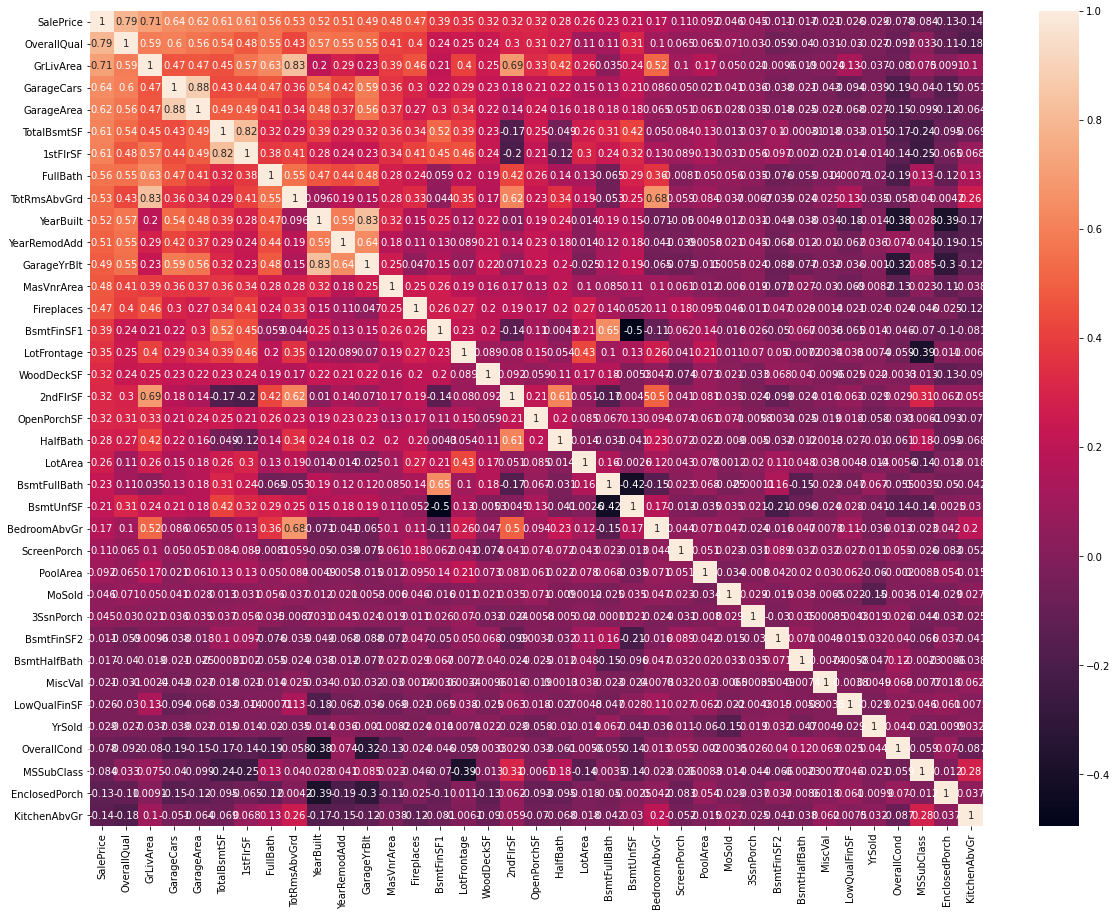

In [4]:
corr=data.corr()
top_corr=data[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

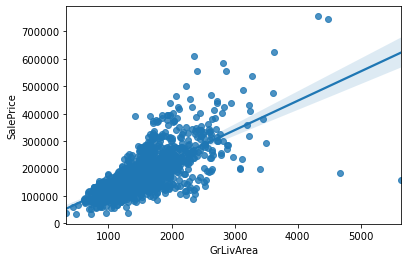

In [5]:
# 두번째로 큰 상관계수를 가진 'GrLivArea' 의 그래프
sns.regplot(data['GrLivArea'], data['SalePrice']) # Outlier가 존재함

In [6]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [7]:
Ytrain=train['SalePrice'] # 타겟 변수를 미리 저장
train=train[list(test)]
all_data=pd.concat((train, test), axis=0)
print(all_data.shape)
Ytrain=np.log(Ytrain+1)  # log를 취해 skew를 없앤다.

(2917, 79)


## 2.3 전체 데이터에서 결측치 확인

In [8]:
# 결측치 제거
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col)
    else:
        pass
print(len(cols))

34


In [9]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


## 2.4 Data 분석

### 1) 총 가용면적 생성

<AxesSubplot:ylabel='SalePrice'>

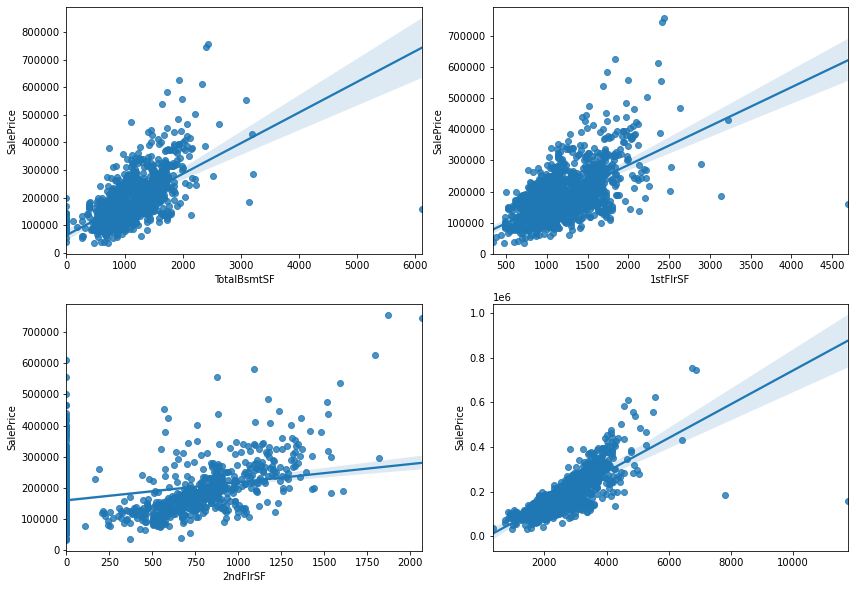

In [10]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.regplot(data['TotalBsmtSF'], data['SalePrice'], ax=ax1)
sns.regplot(data['1stFlrSF'], data['SalePrice'], ax=ax2)
sns.regplot(data['2ndFlrSF'], data['SalePrice'], ax=ax3)
sns.regplot(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], data['SalePrice'], ax=ax4)

In [11]:
# No2ndFlr, NoBsmt 변수를 통해 2층 없음, 지하실 없음 여부를 파악할 수 있도록 함
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

### 2) 총 욕실 수


<AxesSubplot:ylabel='SalePrice'>

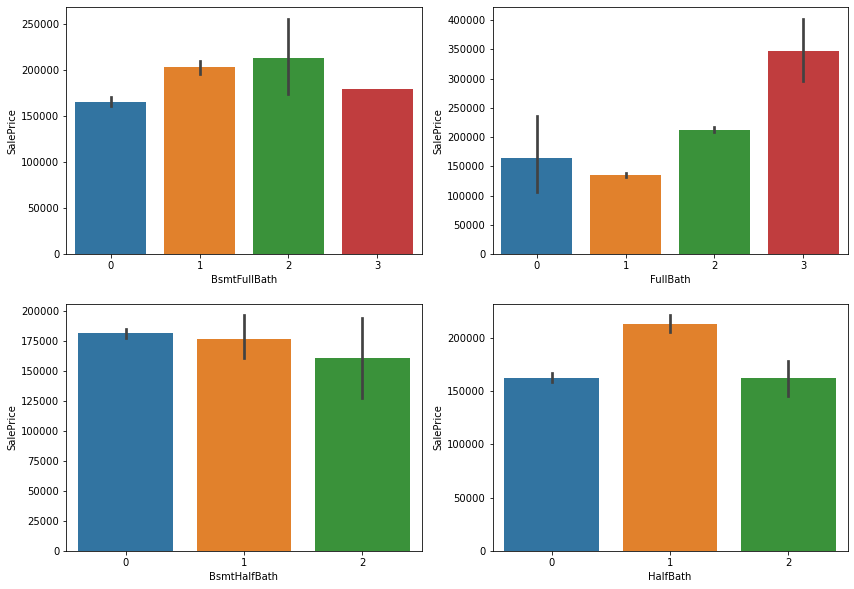

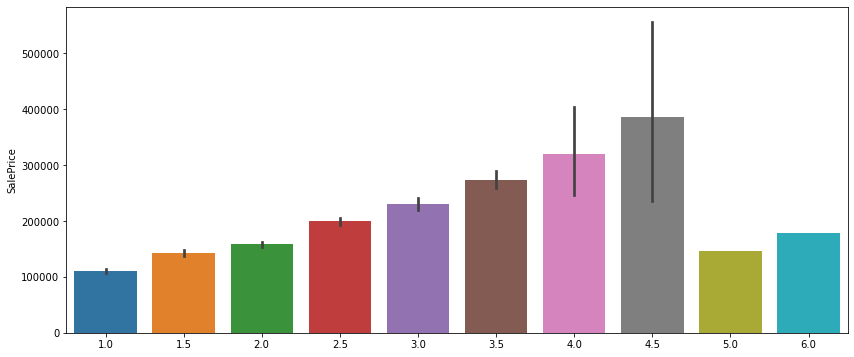

In [12]:
# 지하실에 있는지, full인지 half인지로 이뤄져 있으나, 이를 모두 합함.
# 검정 선은 편차를 나타내는데, 이것이 없는 데이터는 유일한 데이터로 볼 수 있음 == 이상치

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(data['BsmtFullBath'], data['SalePrice'], ax=ax1)
sns.barplot(data['FullBath'], data['SalePrice'], ax=ax2)
sns.barplot(data['BsmtHalfBath'], data['SalePrice'], ax=ax3)
sns.barplot(data['HalfBath'], data['SalePrice'], ax=ax4)

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2), data['SalePrice'], ax=ax5)

In [13]:
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

### 3) 건축 연도 + 리모델링 연도

<AxesSubplot:ylabel='SalePrice'>

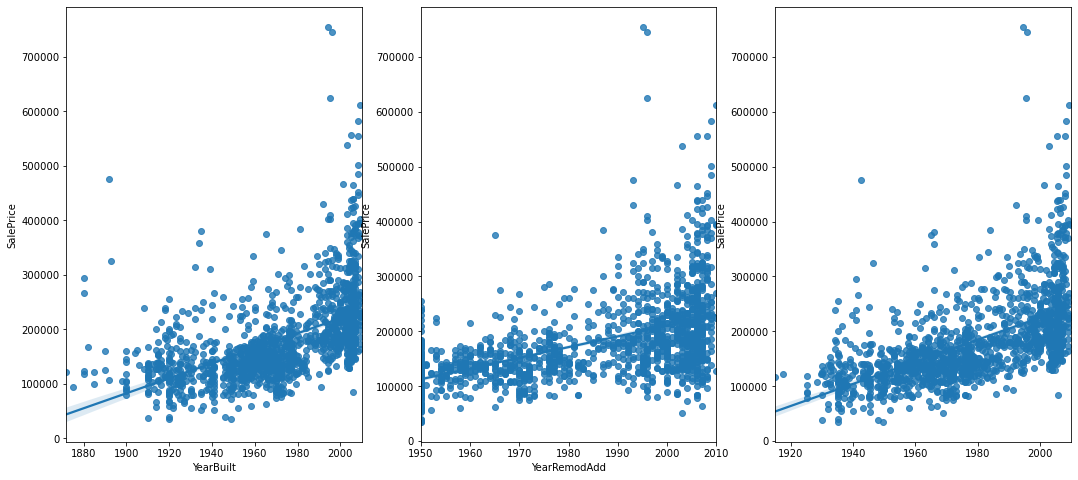

In [14]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(data['YearBuilt'], data['SalePrice'], ax=ax1)
sns.regplot(data['YearRemodAdd'], data['SalePrice'], ax=ax2)
sns.regplot((data['YearBuilt']+data['YearRemodAdd'])/2, data['SalePrice'], ax=ax3) #'/2' for graph scaling


In [15]:
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

### 4) 자료형 수정

In [16]:
all_data['MSSubClass']=all_data['MSSubClass'].astype(str) # 숫자 데이터지만, 범주형 변수임
all_data['MoSold']=all_data['MoSold'].astype(str)         # 판매 연, 월은 연산하지 않으므로 str로 변경
all_data['YrSold']=all_data['YrSold'].astype(str)

### 5) 시설물 점수

In [17]:
# 지하실에 관한 변수들을 묶어 저장한 후
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt=all_data[Basement]

In [18]:
# 이들을 인코딩
Bsmt=Bsmt.replace(to_replace='Po', value=1)
Bsmt=Bsmt.replace(to_replace='Fa', value=2)
Bsmt=Bsmt.replace(to_replace='TA', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)
Bsmt=Bsmt.replace(to_replace='Ex', value=5)
Bsmt=Bsmt.replace(to_replace='None', value=0)

Bsmt=Bsmt.replace(to_replace='No', value=1)
Bsmt=Bsmt.replace(to_replace='Mn', value=2)
Bsmt=Bsmt.replace(to_replace='Av', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)

Bsmt=Bsmt.replace(to_replace='Unf', value=1)
Bsmt=Bsmt.replace(to_replace='LwQ', value=2)
Bsmt=Bsmt.replace(to_replace='Rec', value=3)
Bsmt=Bsmt.replace(to_replace='BLQ', value=4)
Bsmt=Bsmt.replace(to_replace='ALQ', value=5)
Bsmt=Bsmt.replace(to_replace='GLQ', value=6)

In [19]:
# 지하실의 전반적인 상태를 복합적으로 편가할 수 있는 변수 BsmtScore 생성 (종합 점수)
# BsmtDNF: 지하실 미완성 여부
Bsmt['BsmtScore']= Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore']=Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore']=Bsmt['BsmtFin']
all_data['BsmtDNF']=(all_data['BsmtFinScore']==0)

### 6) 토지 점수 (Lot)

In [20]:
lot=['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot=all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage'] * Lot['LotArea'])+1)

all_data['LotScore']=Lot['LotScore']

### 7) 차고 점수

In [22]:
garage=['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage=all_data[garage]
all_data['NoGarage']=(all_data['GarageArea']==0)

In [23]:
Garage=Garage.replace(to_replace='Po', value=1)
Garage=Garage.replace(to_replace='Fa', value=2)
Garage=Garage.replace(to_replace='TA', value=3)
Garage=Garage.replace(to_replace='Gd', value=4)
Garage=Garage.replace(to_replace='Ex', value=5)
Garage=Garage.replace(to_replace='None', value=0)

Garage=Garage.replace(to_replace='Unf', value=1)
Garage=Garage.replace(to_replace='RFn', value=2)
Garage=Garage.replace(to_replace='Fin', value=3)

Garage=Garage.replace(to_replace='CarPort', value=1)
Garage=Garage.replace(to_replace='Basment', value=4)
Garage=Garage.replace(to_replace='Detchd', value=2)
Garage=Garage.replace(to_replace='2Types', value=3)
Garage=Garage.replace(to_replace='Basement', value=5)
Garage=Garage.replace(to_replace='Attchd', value=6)
Garage=Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore']=Garage['GarageScore']

### 8) 기타 변수

In [24]:
# 비정상적으로 하나의 값만 많은 변수들 삭제
all_data=all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

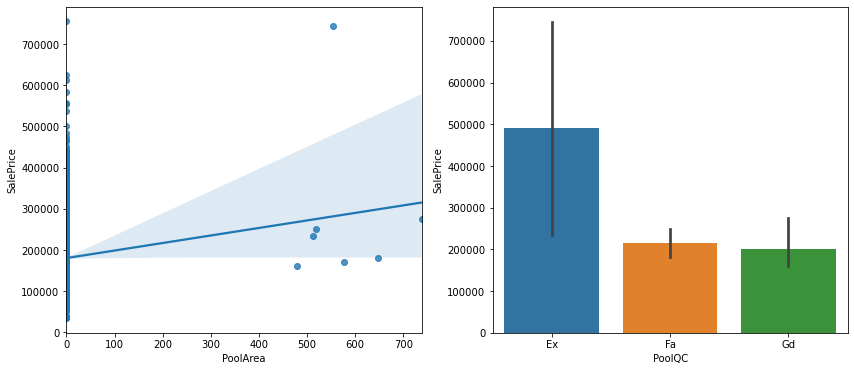

In [26]:
# 비정상적으로 빈 값이 많은 변수들 삭제 - 수영장 있는 집 등..
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='PoolQC', y='SalePrice', ax=ax2)

In [27]:
all_data=all_data.drop(columns=['PoolArea','PoolQC'])

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

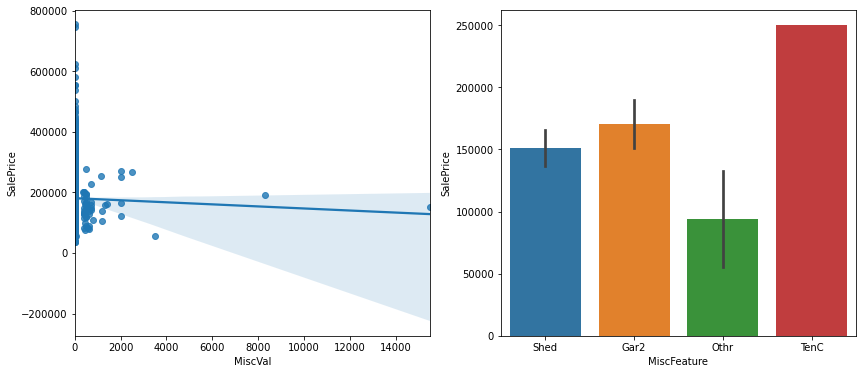

In [28]:
# 테니스 코트 있는 집
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='MiscVal', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='MiscFeature', y='SalePrice', ax=ax2)

In [29]:
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice'>

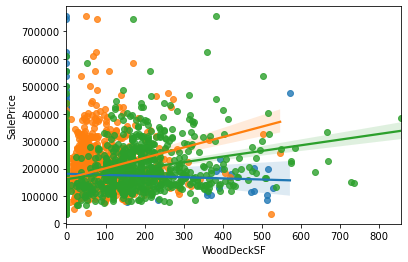

In [30]:
# 결측치가 많은 경우
sns.regplot(data=data, x='LowQualFinSF', y='SalePrice')
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice')
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice')

In [31]:
# 0 값만 분리하면 괜찮을 것 같아서 0만 분리함
all_data['NoLowQual']=(all_data['LowQualFinSF']==0)
all_data['NoOpenPorch']=(all_data['OpenPorchSF']==0)
all_data['NoWoodDeck']=(all_data['WoodDeckSF']==0)

# 3. Preprocessing

## 3.1 Categorical Feature

In [32]:
# 원핫 인코딩 한다
non_numeric=all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) !=0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(all_data[col], prefix=col)
        all_data=pd.merge(all_data, data_encoded, on='Id')
        all_data=all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

(2917, 309)


## 3.2 Numeric Feature

In [33]:
numeric=all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))

255 features had been tranformed
(2917, 309)


In [34]:
# 아까 합친 데이터 나누기
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Xtest.shape)

(1458, 79) (1459, 79)
(1458, 309) (1459, 309)


# 4. Training

In [37]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

import time
#!pip3 install optuna
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, 
                                         min_samples_split=10, loss='huber', random_state=18)

model_XGB=XGBRegressor(colsample_bylevel=0.9229733609038979,colsample_bynode=0.21481791874780318,colsample_bytree=0.607964318297635, 
                       gamma=0.8989889254961725, learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602, 
                       reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
                       tree_method='gpu_hist',verbosity=0)

In [38]:
model_Lasso.fit(Xtrain, Ytrain)
Lasso_predictions=model_Lasso.predict(Xtest)
train_Lasso=model_Lasso.predict(Xtrain)

model_ENet.fit(Xtrain, Ytrain)
ENet_predictions=model_ENet.predict(Xtest)
train_ENet=model_ENet.predict(Xtrain)

model_XGB.fit(Xtrain, Ytrain)
XGB_predictions=model_XGB.predict(Xtest)
train_XGB=model_XGB.predict(Xtrain)

model_GBoost.fit(Xtrain, Ytrain)
GBoost_predictions=model_GBoost.predict(Xtest)
train_GBoost=model_GBoost.predict(Xtrain)

log_train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost)/4
train_score=np.sqrt(mean_squared_error(Ytrain, log_train_predictions))
print(f"Scoring with train data : {train_score}")

log_predictions=(Lasso_predictions + ENet_predictions + XGB_predictions + GBoost_predictions) / 4
predictions=np.exp(log_predictions)-1
submission['SalePrice']=predictions
submission.to_csv('Result.csv')

Scoring with train data : 0.08475252648583813


# 4.1 Training 2

In [40]:
'''import torch
import torch.nn as nn
import numpy as np

class CNN(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init()
        # Layer1
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Layer 2 
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
                
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out
'''

'import torch\nimport torch.nn as nn\nimport numpy as np\n\nclass CNN(torch.nn.Module):\n    def __init__(self):\n        super(Model, self).__init()\n        # Layer1\n        self.layer1 = torch.nn.Sequential(\n            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),\n            torch.nn.ReLU(),\n            torch.nn.MaxPool2d(kernel_size=2, stride=2))\n        \n        # Layer 2 \n        self.layer2 = torch.nn.Sequential(\n            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),\n            torch.nn.ReLU(),\n            torch.nn.MaxPool2d(kernel_size=2, stride=2))\n                \n    def forward(self, x):\n        out = self.layer1(x)\n        out = self.layer2(out)\n        return out\n'

In [66]:
from keras import models
from keras import layers
import torch 

def build_model(): # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(Xtrain.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

import numpy as np

k = 4

torch.Tensor
Xtrain = torch.Tensor(Xtrain, dtype=torch.float32)
Ytrain = torch.Tensor(Ytrain)

num_val_samples = len(Xtrain) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = Xtrain[i * num_val_samples: (i + 1) * num_val_samples]  # 검증 데이터 준비: k번째 분할
    val_targets = Ytrain[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [Xtrain[:i * num_val_samples],
         Xtrain[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [Ytrain[:i * num_val_samples],
         Ytrain[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
          epochs=num_epochs, batch_size=32, verbose=0)
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 검증 세트로 모델 평가
all_scores.append(val_mae)


TypeError: new() received an invalid combination of arguments - got (DataFrame, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [64]:
Xtrain.values

array([[65.0, 9.042040056544483, 7, ..., 0.0, 1, 0.0],
       [80.0, 9.169622538697624, 6, ..., 0.0, 1, 0.0],
       [68.0, 9.328212292571072, 7, ..., 0.0, 1, 0.0],
       ...,
       [66.0, 9.10974625674048, 7, ..., 0.0, 1, 0.0],
       [68.0, 9.181735114965848, 5, ..., 0.0, 1, 0.0],
       [75.0, 9.204121072162266, 5, ..., 0.0, 1, 0.0]], dtype=object)

In [ ]:
all_scores


In [ ]:
np.mean(all_scores)

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]